In [67]:

import mne
from mne.preprocessing import ICA

import pandas as pd
import mtrf
from mtrf.model import TRF
from mtrf.stats import crossval, nested_crossval
import eelbrain as eel

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile, loadmat, savemat
from scipy.signal import hilbert

from collections import Counter

import sys
sys.path.append('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *
from update_sub_lists import*
from ERP_utils import *

import pickle
import os

In [68]:
eeg_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed_15Hz'
mTRF_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/trained_models'
sv_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/sv'


In [69]:

good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
#subjects_to_process = good_error_subjects
#subjects_to_process = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12']
subjects_to_process = ['08']

n_subs = len(subjects_to_process)
print('processing subjects:', subjects_to_process)

periods = ['pre']
#features = 'AM' #AM or onsets

overwrite = False
n_segments = 10
fs = 128
tmin, tmax =-0.5, 0.5  # range of time lag
regularization = 1
#regularizations= [0.0001, 0.01, 1, 100, 10000, 1000000]


processing subjects: ['08']


## Forward model

In [70]:
r_onsets = []
r_firsts= []
for subject in subjects_to_process:
    for period in periods:
        eeg_path = os.path.join(eeg_dir, f'{subject}/eeg_error_{period}_{subject}.mat')

        data = loadmat(eeg_path)
        eeg = data['trial_data']

        sv_data = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))

        onsets_sv = sv_data['onsets'][0] #take 0 index because it's shaped (1, n_timepoints)
        #np.random.shuffle(onsets_sv) #test if the shuffled data indeed yields chance results

        firsts_sv = sv_data['firsts'][0]

        eeg_segments = segment(eeg.T, n_segments)
        eeg_segments_norm = normalize_responses(eeg_segments) #normalize eeg data

        onset_segments = segment(onsets_sv, n_segments) 
        firsts_segments = segment(firsts_sv, n_segments)

        try:
            #training TRF model on onsets
            fwd_trf_onsets = TRF(direction=1)
            r_fwd_onsets = crossval(fwd_trf_onsets, onset_segments, eeg_segments_norm, fs, tmin, tmax, regularization)
            r_onsets.append(r_fwd_onsets)

            #training TRF model on firsts
            fwd_trf_firsts = TRF(direction=1)
            r_fwd_firsts = crossval(fwd_trf_firsts, firsts_segments, eeg_segments_norm, fs, tmin, tmax, regularization)
            r_firsts.append(r_fwd_firsts)

        except ValueError: 
            print(f'failed to train {subject}')
            continue
        #fwd_trf.train(onset_segments, eeg_segments, fs, tmin, tmax, regularization = 1000)
        
        

Cross-validating[##################################################] 10/10

Cross-validating[##################################################] 10/10



In [71]:
r_onsets = np.array(r_onsets)
r_firsts = np.array(r_firsts)

In [72]:
r_diff

NameError: name 'r_diff' is not defined

(array([3., 1., 3., 1., 2., 2., 3., 0., 0., 1.]),
 array([-4.35358573e-04, -2.98356791e-04, -1.61355010e-04, -2.43532278e-05,
         1.12648554e-04,  2.49650336e-04,  3.86652118e-04,  5.23653900e-04,
         6.60655681e-04,  7.97657463e-04,  9.34659245e-04]),
 <BarContainer object of 10 artists>)

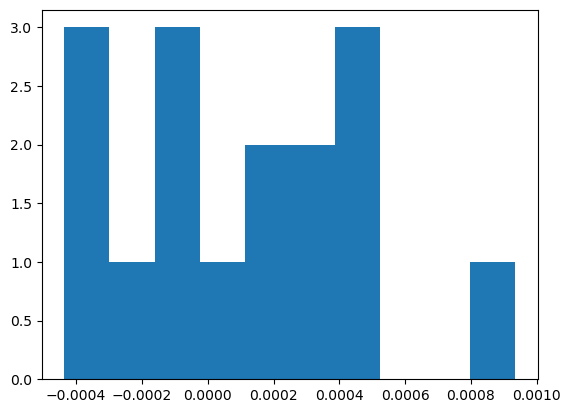

In [ ]:
r_diff = r_firsts - r_onsets
plt.hist(r_diff)

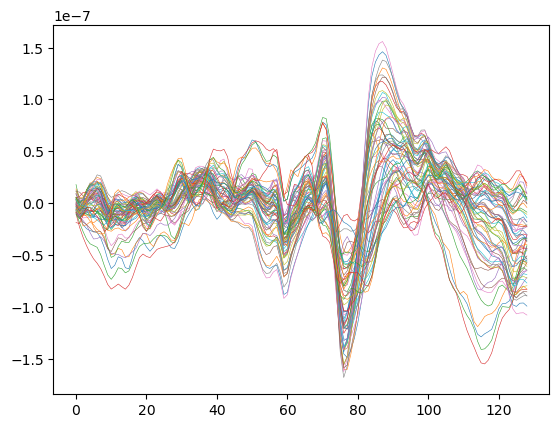

In [ ]:
fwd_trf = TRF(direction=1)
fwd_trf.train(onset_segments, eeg_segments, fs, tmin, tmax, regularization = 1000)
plt.plot(fwd_trf.weights[0], linewidth = 0.4);

## Backwards model

In [73]:
def normalize_responses(responses):
    """Function that normalizes the EEG data
    Data is normalized by subtracting the
    global mean and dividing by the global
    standard deviation of the data to preserve
    relative amplitudes between channels
   
    Args:
    responses: list of numpy arrays, each array
    contains the EEG data for one trial. The
    data must be organized as n_samples x n_channels
    """

    # Check dimensions
    if isinstance(responses, list):
        n_rows, n_cols = responses[0].shape
        if n_rows < n_cols:
            raise Exception('Data should be a list of numpy arrays with dimesions n_samples x n_channels')
        responses_concatenated = np.concatenate(responses, axis=0).flatten()
    else:
        raise Exception('Data should be a list of numpy arrays with dimesions n_samples x n_channels')

    global_mean = np.mean(responses_concatenated)
    global_std = np.std(responses_concatenated)
    responses = [(response - global_mean) / global_std for response in responses]

    return responses


In [74]:
subjects_to_process = ['08']
train = 'listen' #listen or error
periods = ['pre']

for subject in subjects_to_process:
    for period in periods:

        if train == 'error':
            eeg_path = os.path.join(eeg_dir, f'{subject}/eeg_error_{period}_{subject}.mat')
            
            data = loadmat(eeg_path)
            eeg = data['trial_data']

            sv_data = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))
            onsets_sv = sv_data['onsets'][0] #take 0 index because it's shaped (1, n_timepoints)

        elif train == 'listen':
            eeg_path = os.path.join(eeg_dir, f'{subject}/eeg_listen_{period}_{subject}.mat')

            data = loadmat(eeg_path)
            eeg = data['trial_data']
 
            events_sv = data['events']
            events_arr = make_raw_events(events_sv)
            events_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
            onset_indices = events_keystrokes[:,0]
            onsets_sv = np.zeros_like(events_sv[0])
            onsets_sv[onset_indices] = 1
        
        

        eeg_segments = segment(eeg.T, n_segments)
        eeg_segments_norm = normalize_responses(eeg_segments)

        onset_segments = segment(onsets_sv, n_segments) 

        print(onset_segments[0].shape)

        #train model
        bwd_trf = TRF(direction = -1)
        bwd_trf.train(onset_segments, eeg_segments_norm, fs, tmin, tmax, regularization = 1)

        # fwd_trf = TRF(direction = 1)
        # fwd_trf.train(onset_segments[1:10], eeg_segments_norm[1:10], fs, tmin, tmax, regularization = 0.4)

        
        

(8512,)


In [76]:
bwd_trf.weights

array([[[-0.04273298],
        [-0.07400435],
        [-0.00178849],
        ...,
        [ 0.0506863 ],
        [ 0.05520806],
        [ 0.0322677 ]],

       [[-0.01721686],
        [-0.01308919],
        [ 0.00958283],
        ...,
        [-0.05762364],
        [-0.01005771],
        [ 0.16082878]],

       [[-0.10583031],
        [-0.05379699],
        [ 0.07399274],
        ...,
        [-0.04953137],
        [-0.12107197],
        [-0.12878248]],

       ...,

       [[-0.10223356],
        [-0.05358697],
        [ 0.04732648],
        ...,
        [ 0.09681117],
        [ 0.11190032],
        [ 0.08902326]],

       [[-0.1336537 ],
        [-0.11457903],
        [-0.05382437],
        ...,
        [ 0.01474485],
        [-0.00622545],
        [-0.08439871]],

       [[ 0.10785613],
        [ 0.00193589],
        [ 0.01442362],
        ...,
        [ 0.05429322],
        [-0.01528516],
        [-0.13893503]]])

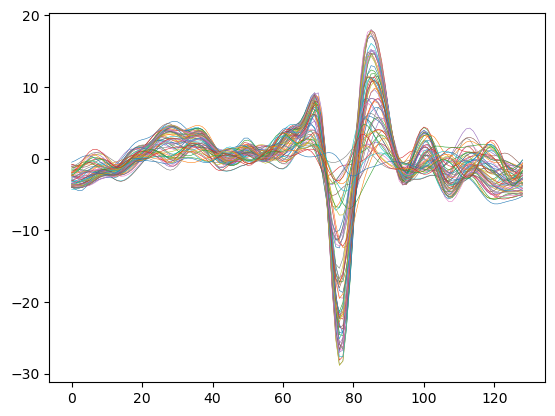

In [ ]:
plt.plot(fwd_trf.weights[0,:,:], linewidth = 0.4);

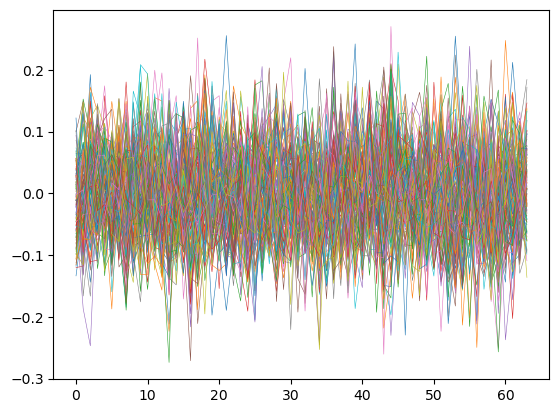

In [ ]:
#plt.plot(bwd_trf.weights[:,:,0], linewidth = 0.4);

In [ ]:
#load error data

data_err = loadmat(os.path.join(eeg_dir, f'{subject}/eeg_error_{period}_{subject}.mat'))
eeg_err = data_err['trial_data'].T
eeg_segments_err = segment(eeg_err, n_segments)
eeg_segments_err_norm = normalize_responses(eeg_segments_err)

sv_data_err = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))
onsets_sv_err = sv_data_err['onsets'][0]
firsts_sv_err = sv_data_err['firsts'][0]
onsets_segments_err = segment(onsets_sv_err,n_segments)

In [ ]:

res = bwd_trf.predict(stimulus = onsets_segments_err, response = eeg_segments_err_norm)
prediction = res[0]
prediction = np.stack(prediction).squeeze()
pred_concat = prediction.reshape(-1)

Text(0, 0.5, 'amplitude')

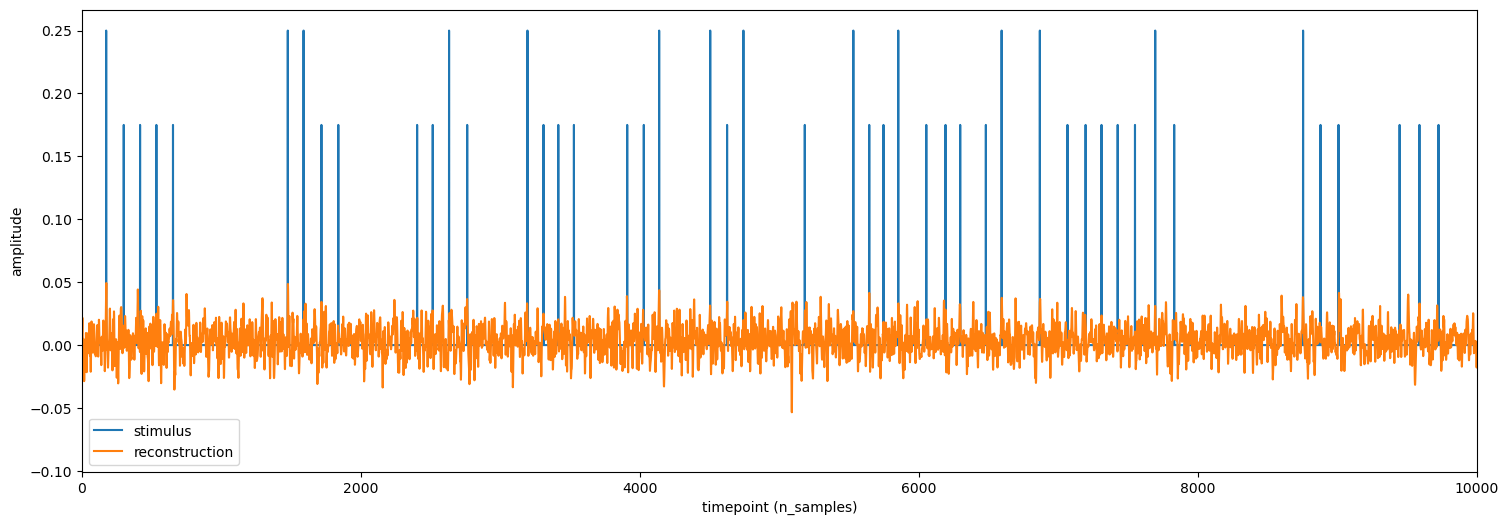

In [ ]:

plt.figure(figsize = (18,6))
plt.plot(firsts_sv_err/4, label = 'stimulus')
plt.plot(pred_concat, label = 'reconstruction')
plt.xlim(0,10000)
#plt.eventplot(others_times)
# for i in range(10):
#     plt.plot(res[0][i][:,0])

plt.legend(loc = 'lower left')
plt.xlabel('timepoint (n_samples)')
plt.ylabel('amplitude')

In [ ]:
res[1]

0.08576630612540014

In [73]:
fo_df = pd.read_csv('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mapchange_csv_corrected/mapchange_keystrokes_pre_09.csv')
others_times = fo_df[fo_df['type']=='other']['time']
firsts_times = fo_df[fo_df['type']=='first']['time']



In [71]:
pred_concat[others_times].mean()

0.05280527405185704

In [74]:
pred_concat[firsts_times].mean()

0.054842472886196335

In [69]:
pred_concat[257]

0.03962261561977407

In [63]:
fo_df

,Unnamed: 0,keystroke_idx,time,type,prev_keystrokes
0,0,0,128,first,0.0
1,1,1,257,other,NaN
2,2,2,608,other,NaN
3,3,3,737,other,NaN
4,4,4,867,other,NaN
...,...,...,...,...,...
389,389,389,75906,other,NaN
390,390,390,76263,other,NaN
391,391,391,76401,other,NaN
392,392,392,76525,other,NaN


In [ ]:
pred_concat

In [49]:
pred_concat.shape

(76800,)

Text(0.5, 1.0, 'onset (training stimulus)')

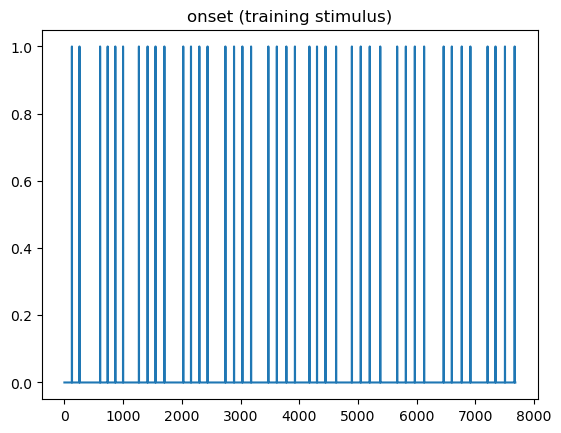

In [70]:
plt.plot(onset_segments[0])
plt.title('onset (training stimulus)')